# Data Analysis

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
%matplotlib inline
# Custom utility functions shared across notebooks
import utils

## EDA & Visualization

In [2]:
period_len = 174 # Maximum number of months for which data exists
airlines = ['AA', 'DL', 'UA'] # Airlines of interest in forecasting
passengers_df = utils.load_data(airlines, category='Passengers') # Monthly passenger counts
flights_df = utils.load_data(airlines, category='Flights') # Monthly flight counts
asm_df = utils.load_data(airlines, category='ASM') # Monthly available seat miles
rpm_df = utils.load_data(airlines, category='RPM') # Monthly revenue passenger miles

# Fetch complete datasets only / ensure that 174 months of data exist for dataframes in each category
assert passengers_df.shape[1] == flights_df.shape[1] == asm_df.shape[1] == rpm_df.shape[1] == period_len

In [3]:
DATES = pd.date_range(start='2016-04-01', end='2017-03-01', freq='MS').to_pydatetime()

def plot_metric(df, airline, airport):
    plt.figure(figsize=(20, 8))
    df.loc[airline + '-' + airport].plot()
    plt.title('Monthly {0}-{1} {2}'.format(airline, airport, df.index.name), fontsize=20)
    plt.setp(plt.xticks()[1], rotation=45, fontsize=14)
    plt.show()

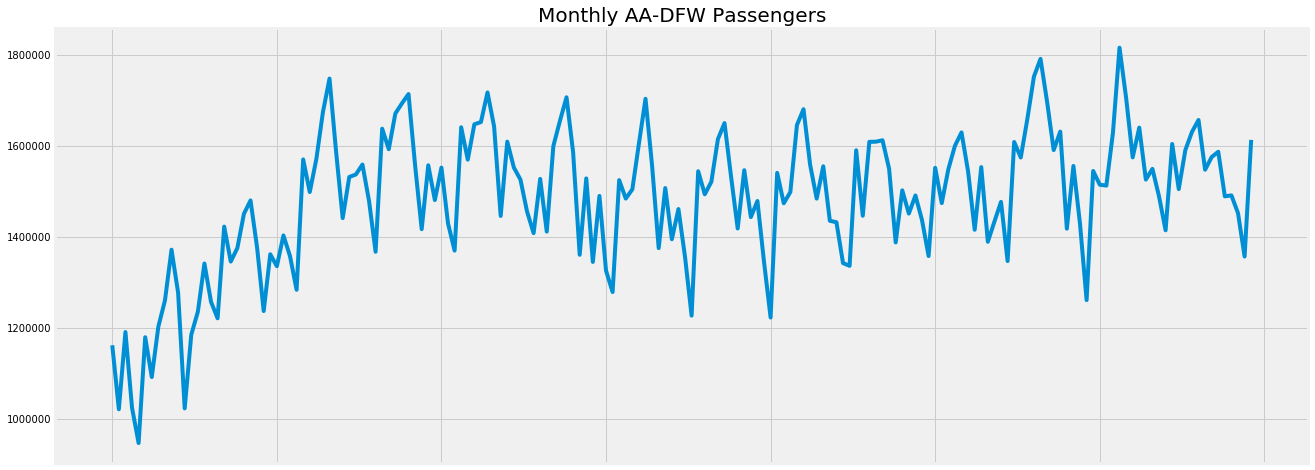

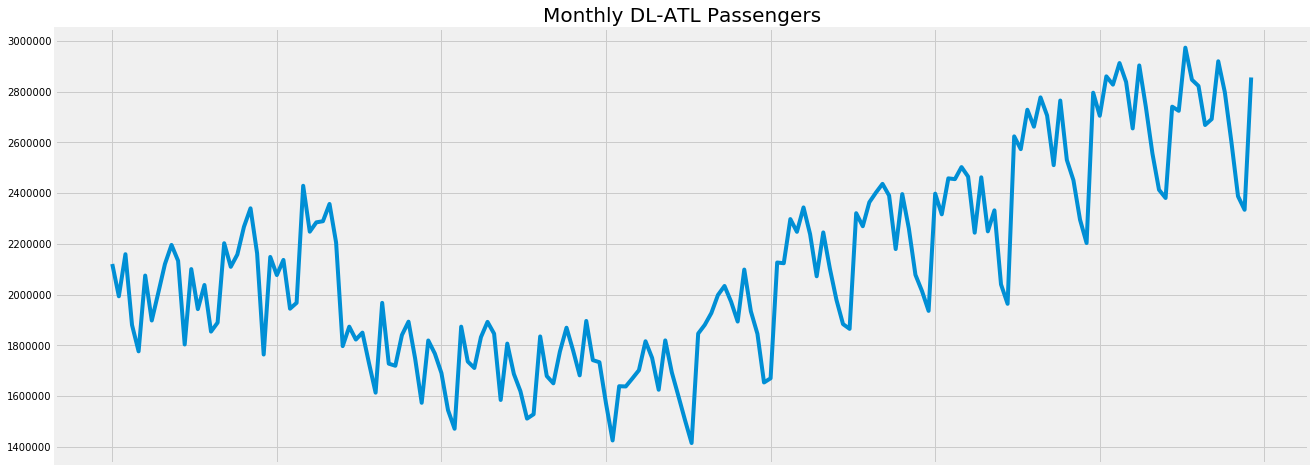

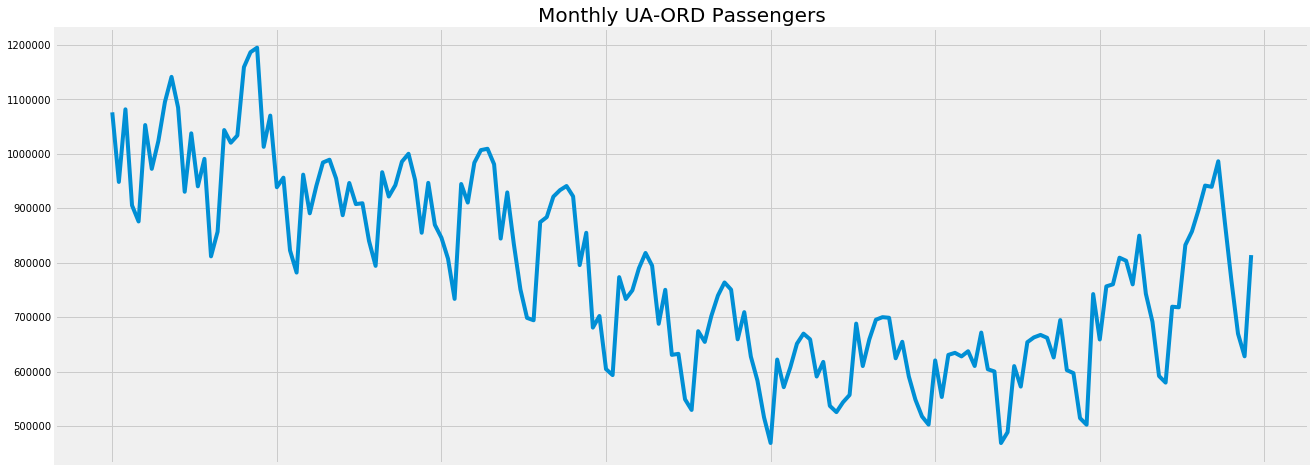

In [4]:
airline_airports = [('AA', 'DFW'), ('DL', 'ATL'), ('UA', 'ORD')]
for combo in airline_airports:
    airline, airport = combo
    plot_metric(df=passengers_df, airline=airline, airport=airport)

## Task Definition

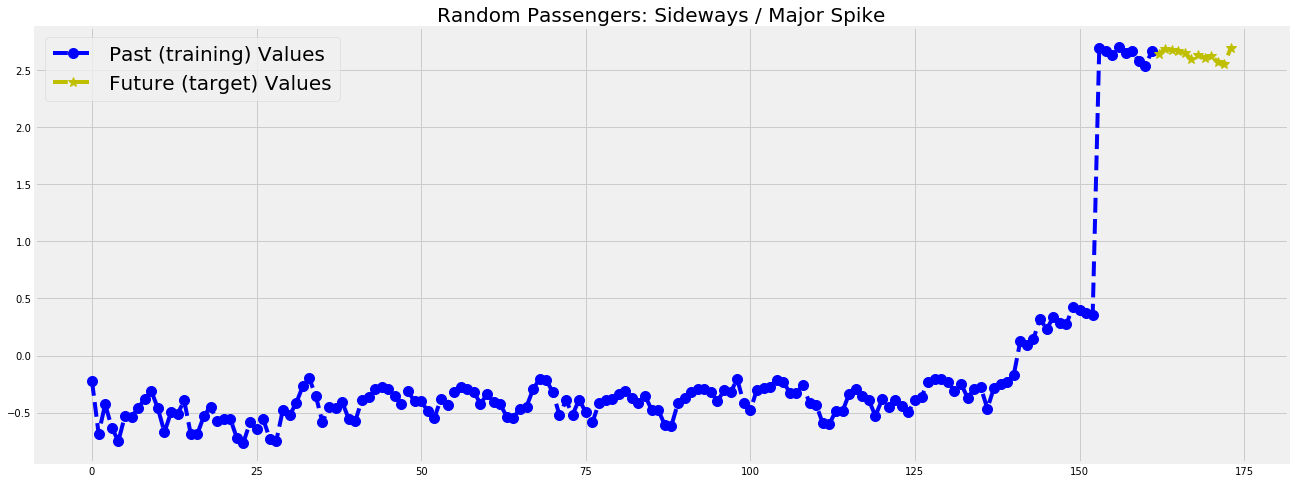

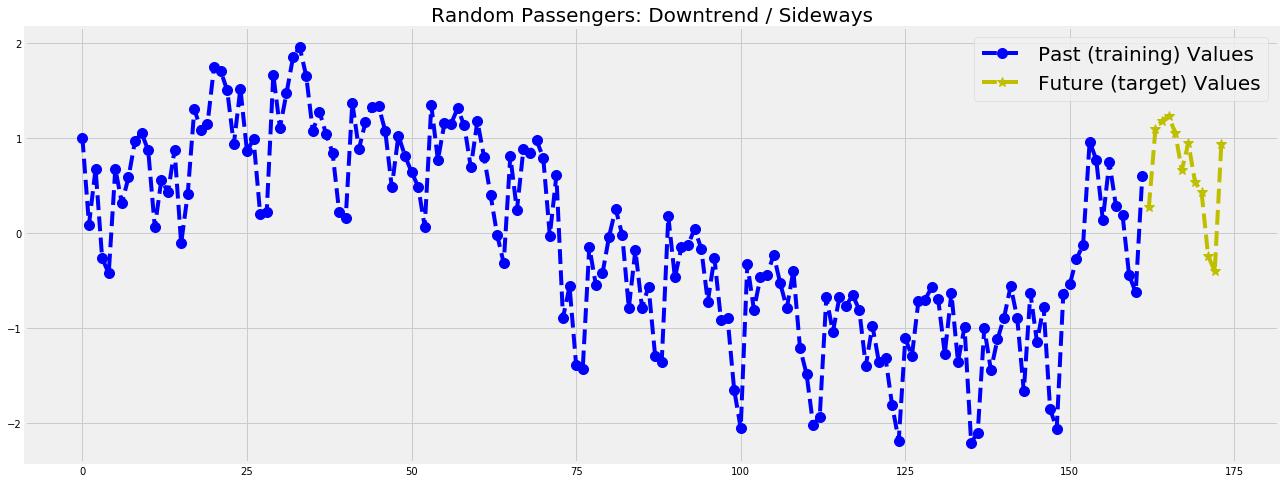

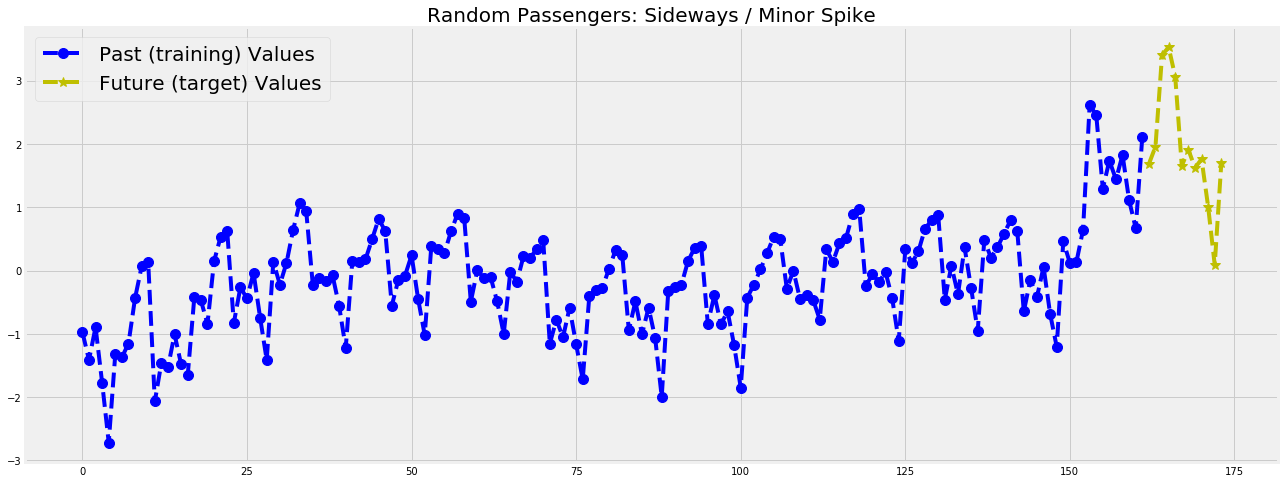

In [5]:
# Task parameters
batch_size = 3 # How many time series to fetch at a time
output_seq_len = 12 # How many months to set aside for forecasting
input_seq_len = period_len - output_seq_len # How many historical months to train on

# Fetch three example sets of training and target values from passengers dataset
_, sample_X, sample_y = utils.fetch_sample(df=passengers_df, output_seq_len=output_seq_len, batch_size=batch_size, random_state=21)

# Demonstrate several types of trends that are common in the datasets
label_0 = "Past (training) Values"
label_1 = "Future (target) Values"

title_0 = "Random Passengers: Sideways / Major Spike"
title_1 = "Random Passengers: Downtrend / Sideways"
title_2 = "Random Passengers: Sideways / Minor Spike"
for i in range(sample_X.shape[1]):
    plt.figure(figsize=(20, 8))
    plt.plot(range(len(sample_X)), sample_X[:,i], "o--b", label=label_0, ms=10)
    plt.plot(range(len(sample_X), len(sample_X) + len(sample_y)), sample_y[:,i], "*--y", label=label_1, ms=10)
    plt.legend(loc='best', fontsize=20)
    if i == 0:  
        plt.title(title_0, fontsize=20)
    elif i == 1:
        plt.title(title_1, fontsize=20)
    else:
        plt.title(title_2, fontsize=20)
    plt.show()

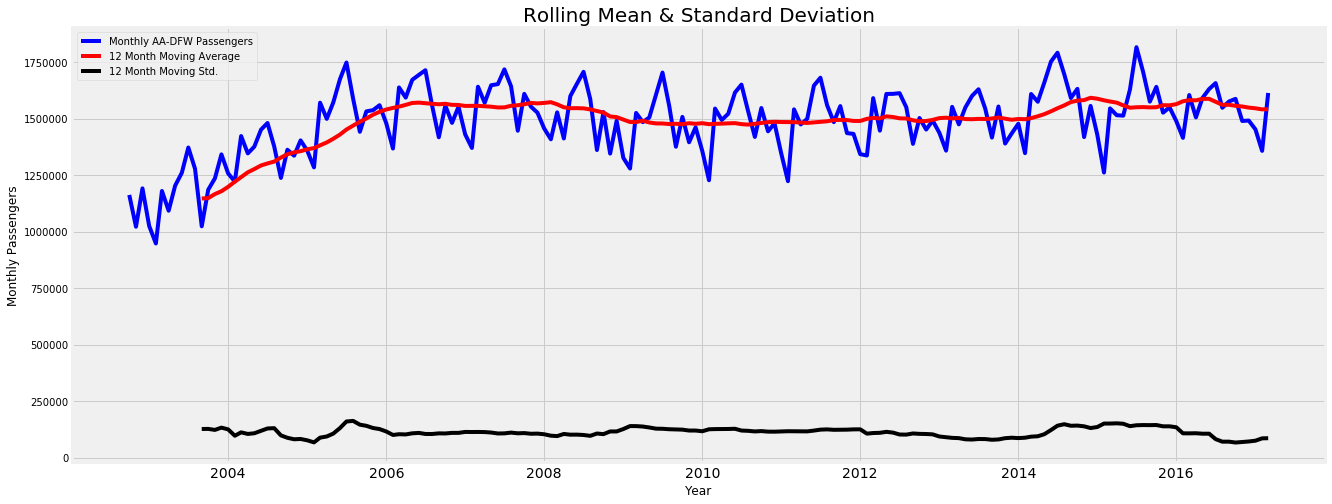

Results of Dickey-Fuller Test:
Test Statistic                  -3.759064
p-value                          0.003355
#Lags Used                      14.000000
Number of Observations Used    159.000000
Critical Value 5%               -2.879895
Critical Value 1%               -3.472161
Critical Value 10%              -2.576557
dtype: float64


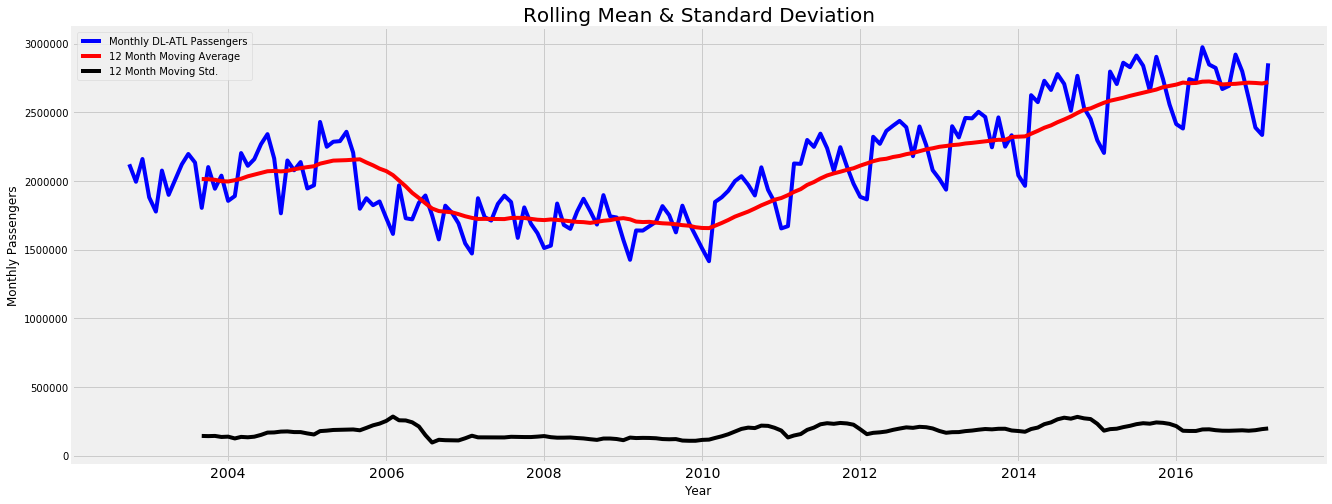

Results of Dickey-Fuller Test:
Test Statistic                  -0.242458
p-value                          0.933268
#Lags Used                      12.000000
Number of Observations Used    161.000000
Critical Value 5%               -2.879665
Critical Value 1%               -3.471633
Critical Value 10%              -2.576434
dtype: float64


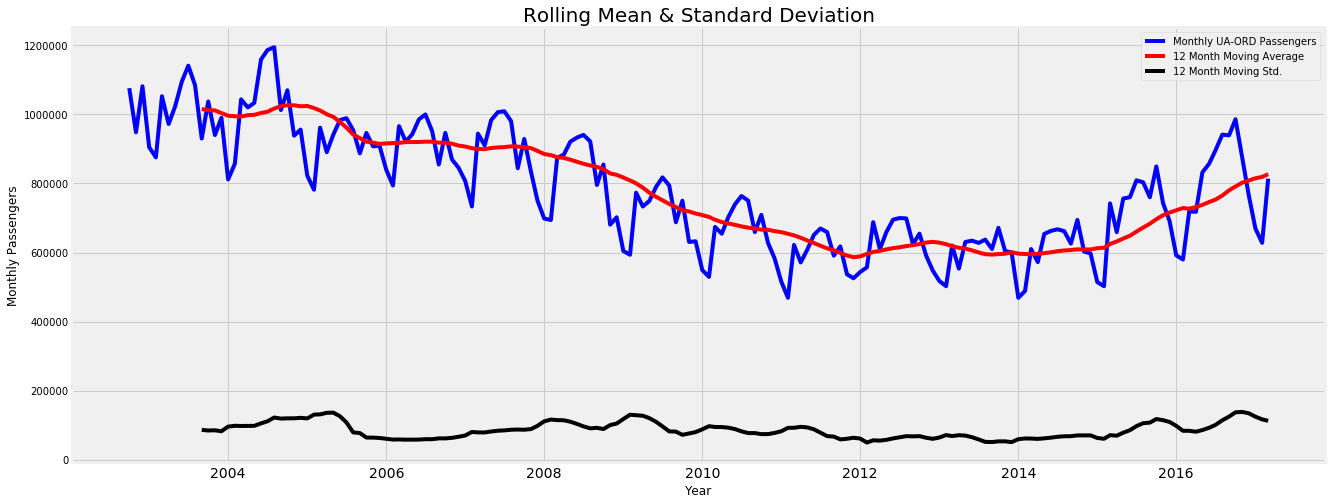

Results of Dickey-Fuller Test:
Test Statistic                  -1.350138
p-value                          0.605934
#Lags Used                      14.000000
Number of Observations Used    159.000000
Critical Value 5%               -2.879895
Critical Value 1%               -3.472161
Critical Value 10%              -2.576557
dtype: float64


In [6]:
# Test the stationarity of the series of interest in their raw forms
for combo in airline_airports:
    airline, airport = combo
    utils.test_stationarity(df=passengers_df, airline=airline, airport=airport, lag=12)

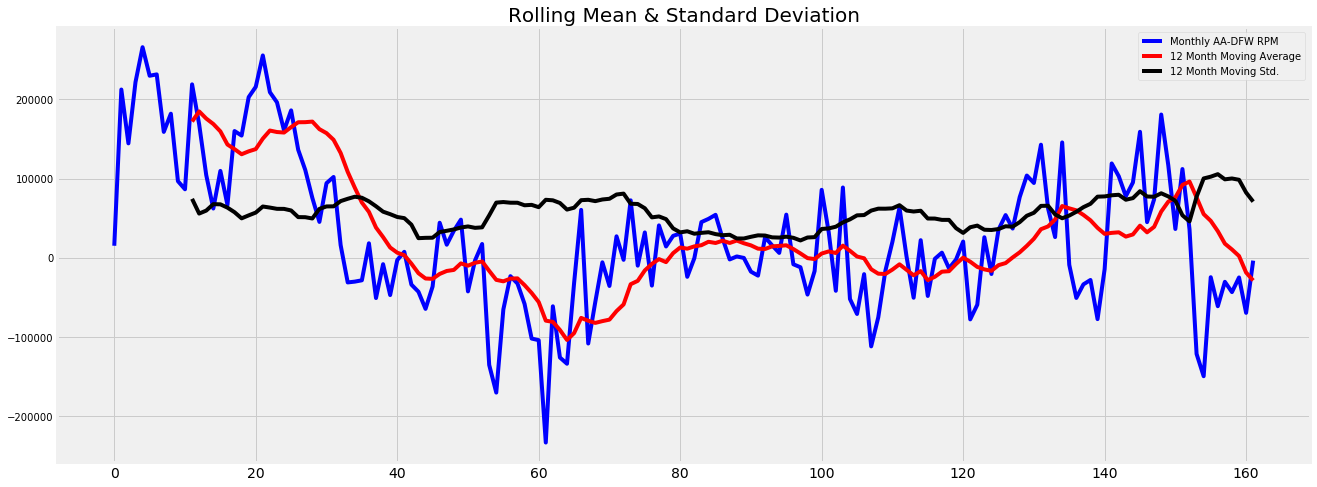

Results of Dickey-Fuller Test:
Test Statistic                  -2.120991
p-value                          0.236158
#Lags Used                      13.000000
Number of Observations Used    148.000000
Critical Value 5%               -2.881275
Critical Value 1%               -3.475325
Critical Value 10%              -2.577293
dtype: float64


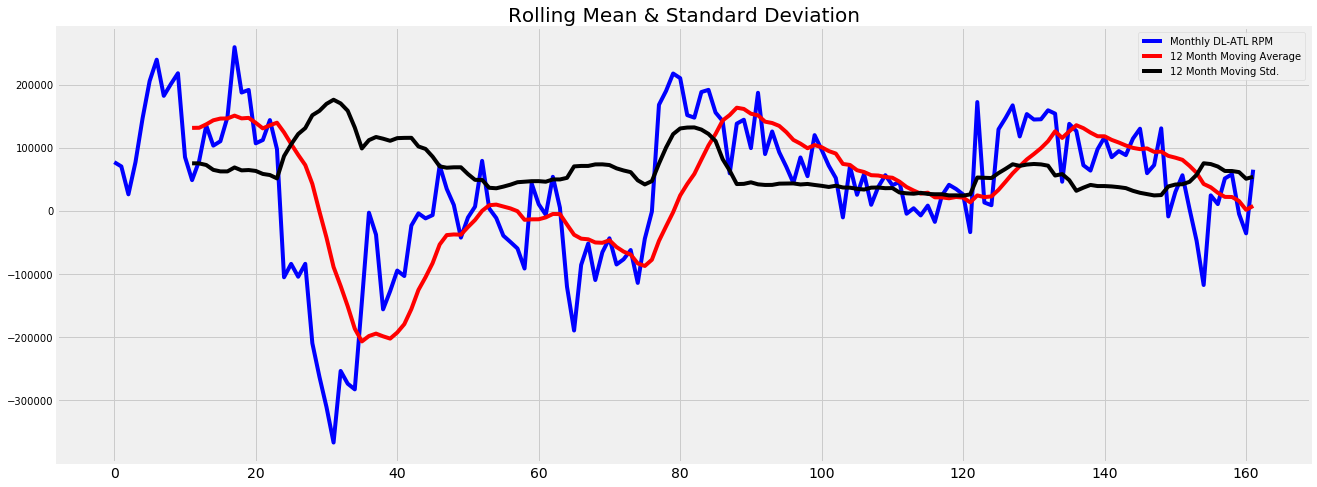

Results of Dickey-Fuller Test:
Test Statistic                  -2.732290
p-value                          0.068615
#Lags Used                      12.000000
Number of Observations Used    149.000000
Critical Value 5%               -2.881141
Critical Value 1%               -3.475018
Critical Value 10%              -2.577221
dtype: float64


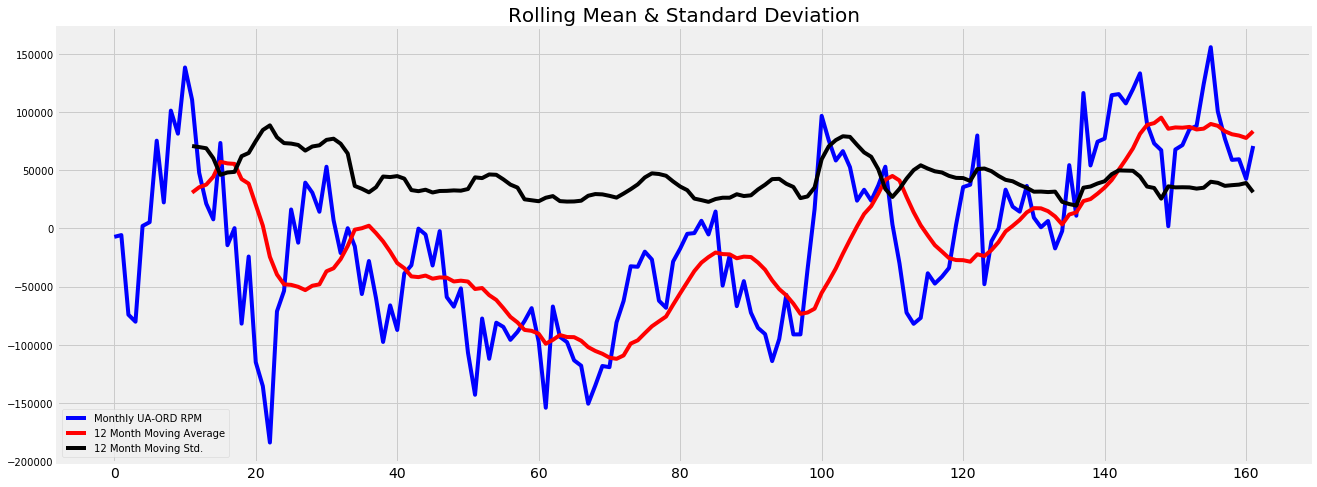

Results of Dickey-Fuller Test:
Test Statistic                  -1.295792
p-value                          0.631095
#Lags Used                      12.000000
Number of Observations Used    149.000000
Critical Value 5%               -2.881141
Critical Value 1%               -3.475018
Critical Value 10%              -2.577221
dtype: float64


In [13]:
# Test the stationarity of the series of interest after attempting to remove seasonality
for combo in airline_airports:
    airline, airport = combo
    utils.test_stationarity(df=rpm_df, airline=airline, airport=airport, lag=12, deseason=True)

## Benchmark Model

In [8]:
def median_forecast(df, airline, airport, lag):
    
    series = df.loc[airline + '-' + airport]
    y_test = series[-lag:]
    preds = np.tile(series[-(lag * 2):].median(), lag)
    MAPE_score = utils.MAPE(y_test, preds)
    
    label_0 = "Future (target) Values"
    label_1 = "Future (predicted) values"
    title = "Median Model // {0}-{1}: Monthly {2} (MAPE = {3}%)".format(airline, airport, df.index.name, MAPE_score)
    
    plt.figure(figsize=(20, 8))
    plt.plot(DATES, y_test, '*--', c='#ee7600', label=label_0, ms=20)
    plt.plot(DATES, preds, '^--', c='#0d7629', label=label_1, ms=20)
    plt.xlabel("Date (YYYY-MM)")
    plt.ylabel("Monthly {}".format(df.index.name))
    plt.legend(loc='best', fontsize=20)
    plt.title(title, fontsize=20)
    plt.setp(plt.xticks()[1], rotation=45, fontsize=14)
    plt.show()

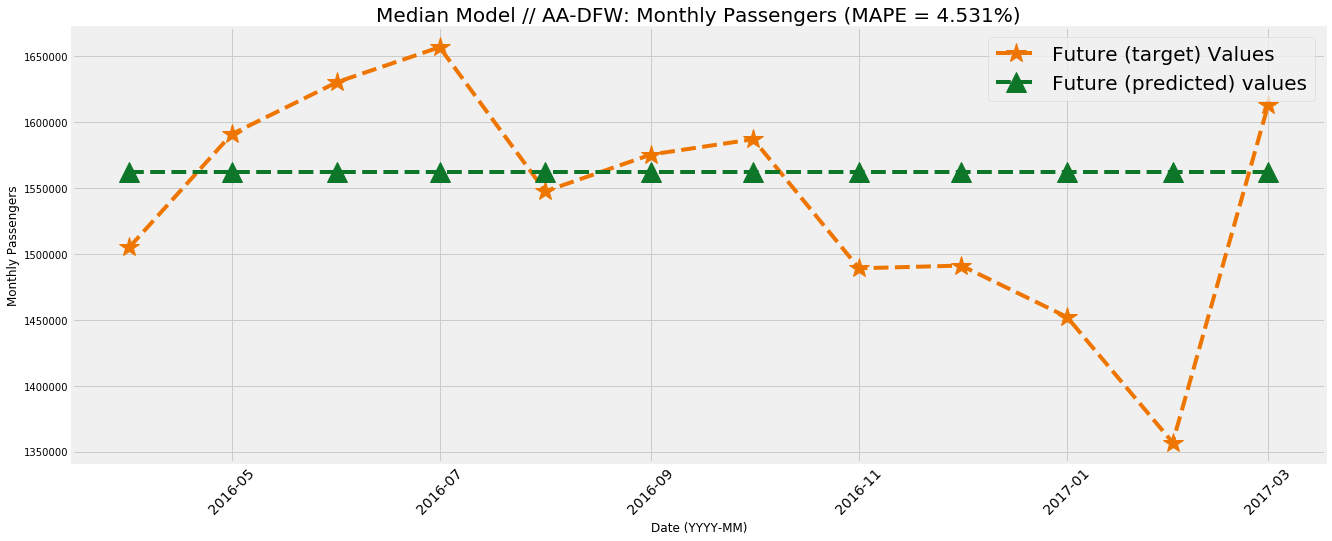

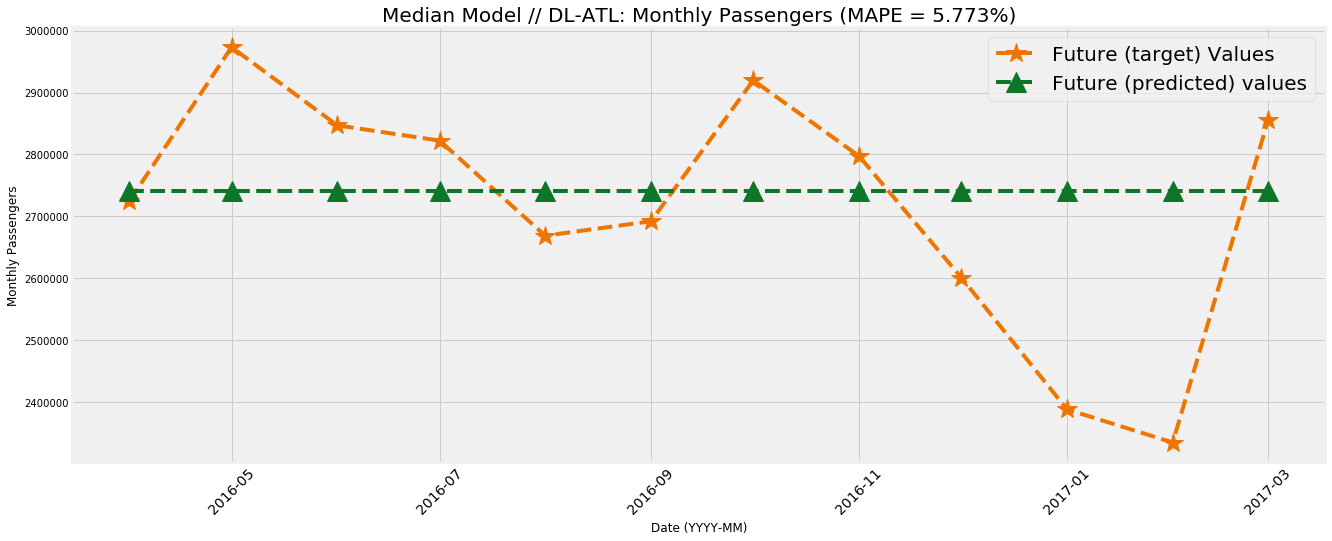

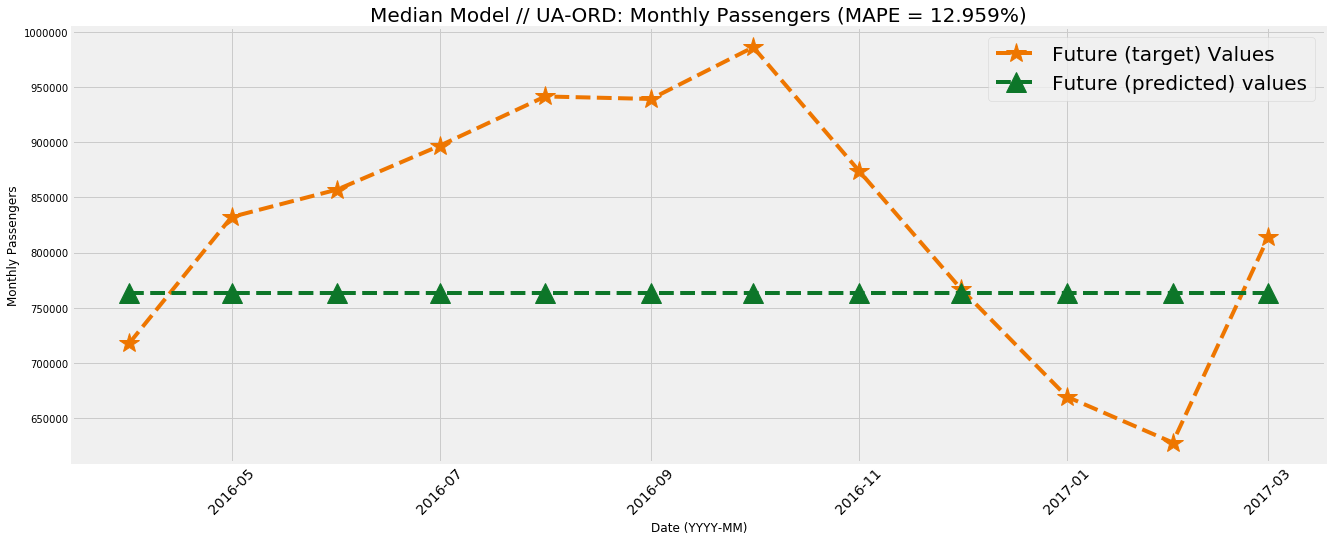

In [10]:
for combo in airline_airports:
    airline, airport = combo
    median_forecast(df=passengers_df, airline=airline, airport=airport, lag=12)

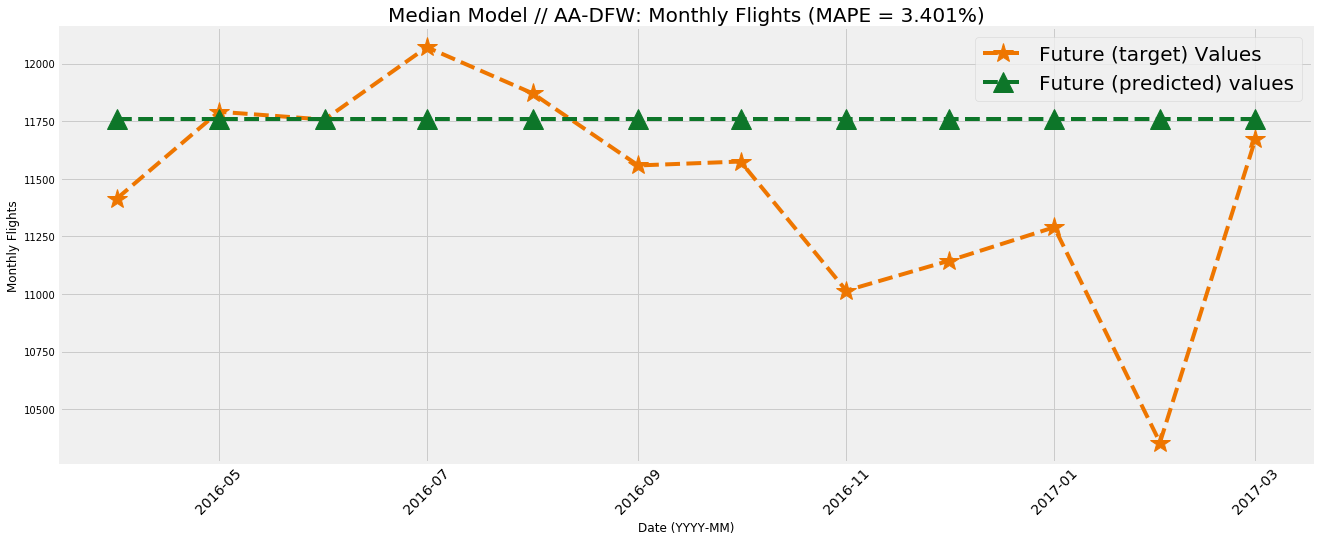

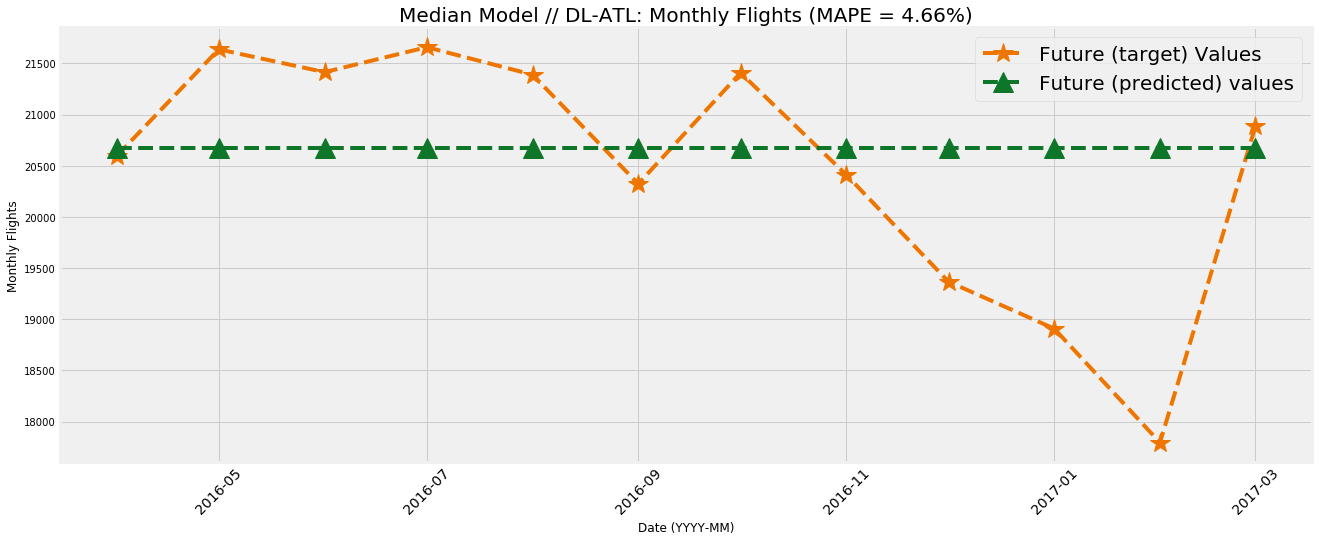

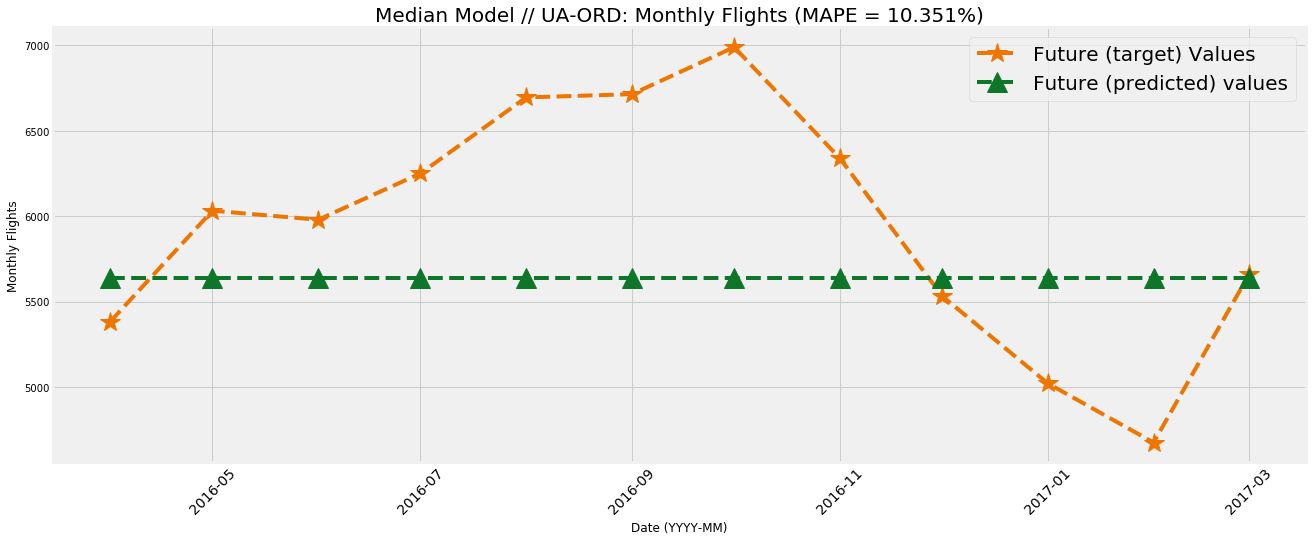

In [11]:
for combo in airline_airports:
    airline, airport = combo
    median_forecast(df=flights_df, airline=airline, airport=airport, lag=12)

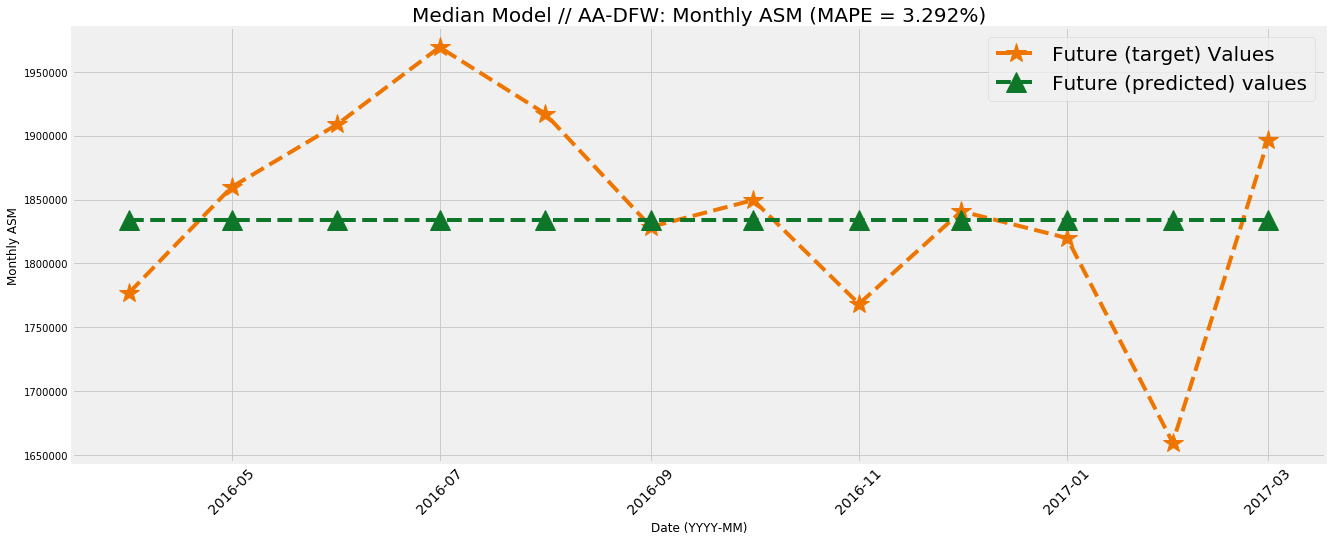

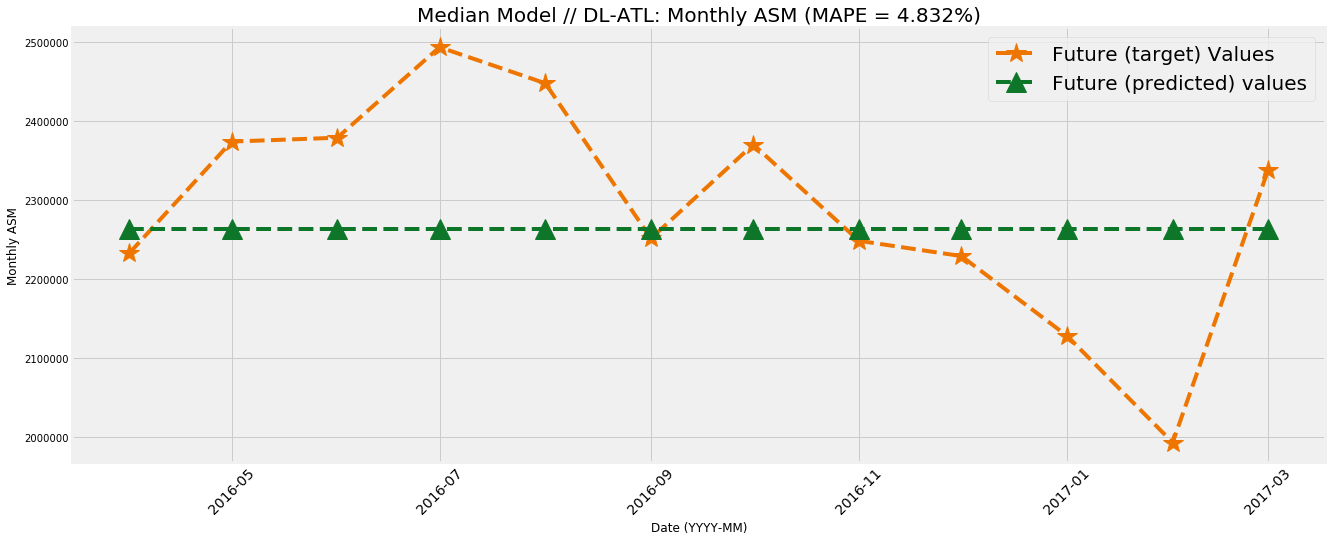

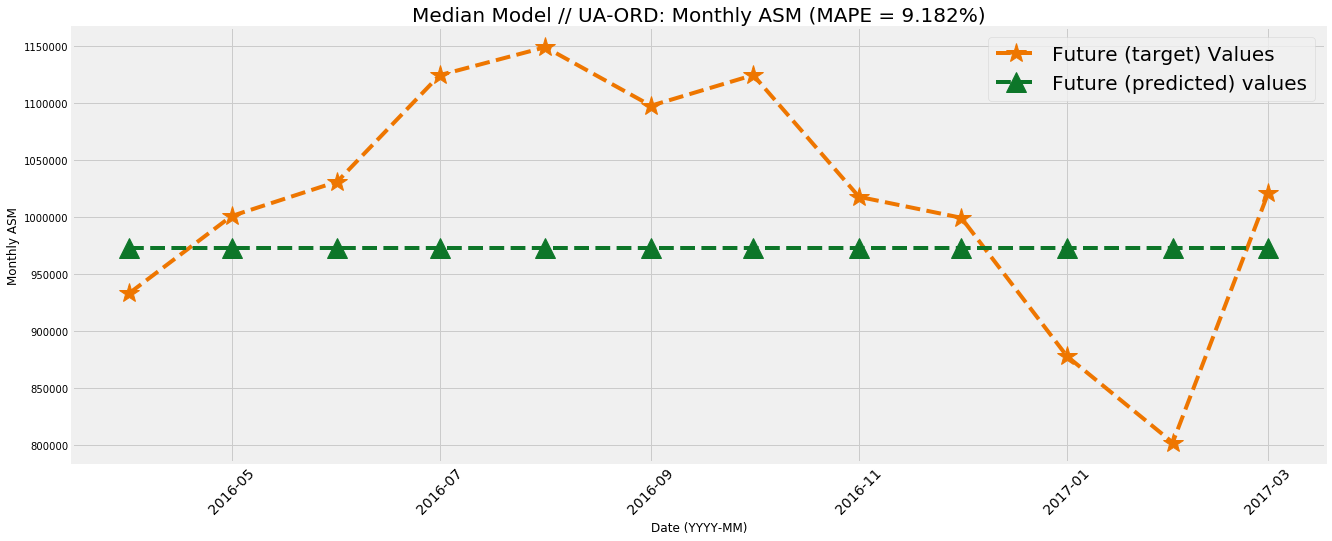

In [12]:
for combo in airline_airports:
    airline, airport = combo
    median_forecast(df=asm_df, airline=airline, airport=airport, lag=12)

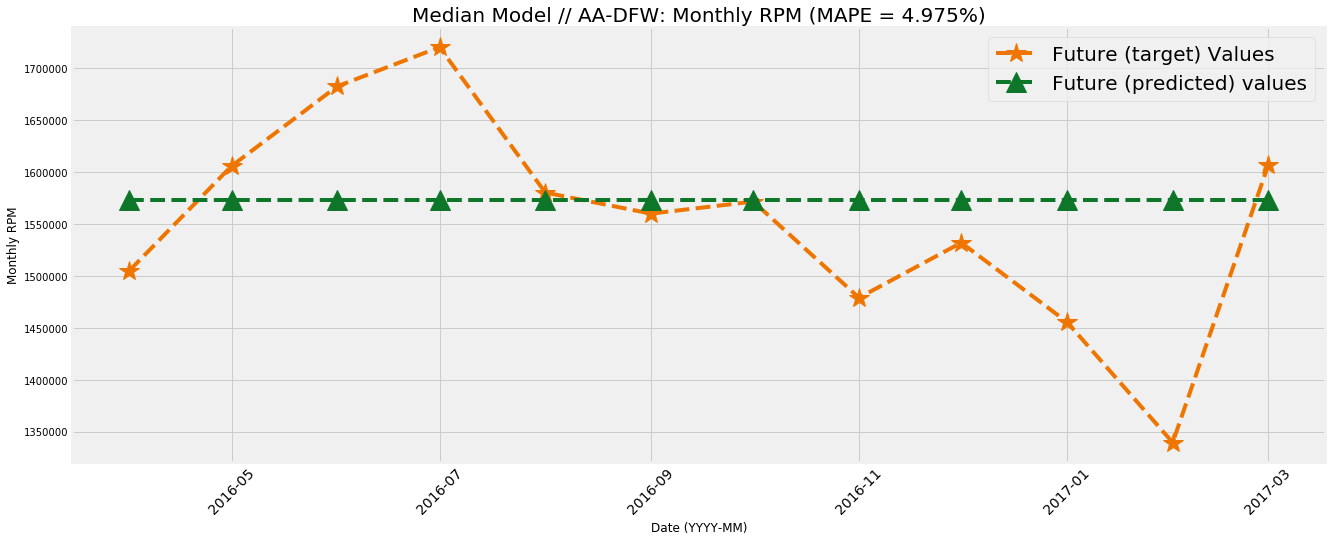

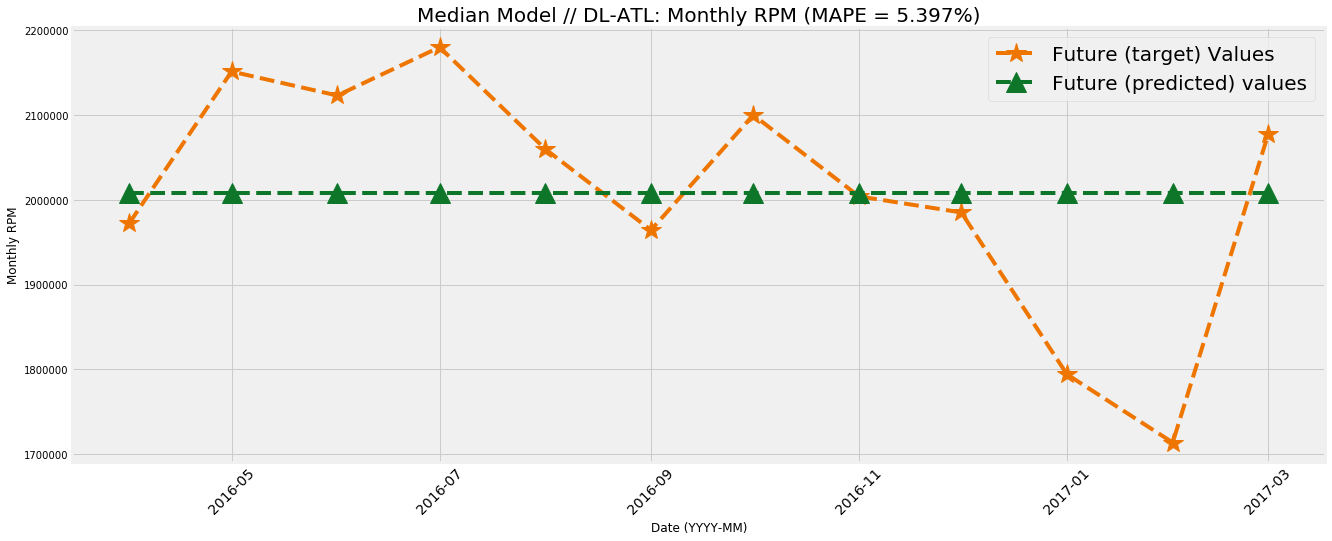

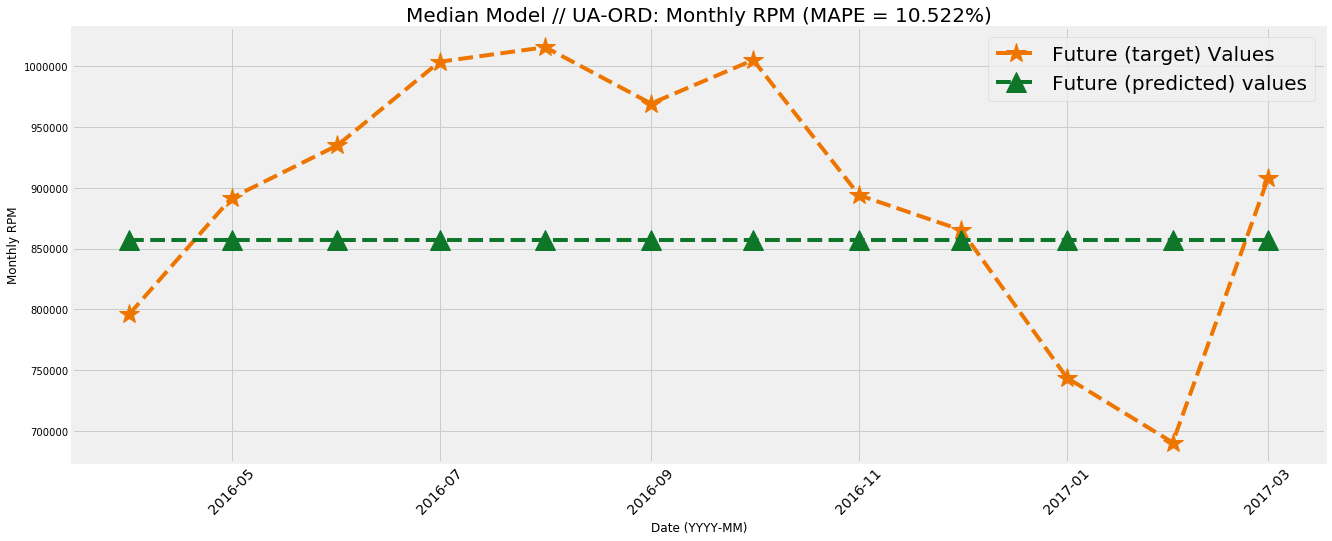

In [13]:
for combo in airline_airports:
    airline, airport = combo
    median_forecast(df=rpm_df, airline=airline, airport=airport, lag=12)